<a href="https://colab.research.google.com/github/lgb201020/AI_homework/blob/main/AI_HW_202017861_%EC%9D%B4%EA%B8%B0%EB%B0%B1_%EC%88%98%EC%A0%95%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Google Colab에서 노트북을 실행하실 때에는
# https://tutorials.pytorch.kr/beginner/colab 를 참고하세요.
%matplotlib inline

# 2024-1 Artificial Intelligence HW
### due date : 6/23 (Sun) 24:00

https://tutorials.pytorch.kr/beginner/transfer_learning_tutorial.html

메뉴 --> 런타임 --> 런타임 유형 변경 --> GPU 선택 추천

본 노트에 있는 전체 내용을 반드시 읽어보길 바랍니다.


# 컴퓨터 비전(Vision)을 위한 전이학습(Transfer Learning)

**Author**: [Sasank Chilamkurthy](https://chsasank.github.io)
  **번역**: [박정환](http://github.com/9bow)

이 튜토리얼에서는 전이학습(Transfer Learning)을 이용하여 이미지 분류를 위한
합성곱 신경망을 어떻게 학습시키는지 배워보겠습니다. 전이학습에 대해서는
[CS231n 노트](http://cs231n.github.io/transfer-learning/)_ 에서 더 많은 내용을
읽어보실 수 있습니다.

위 노트를 인용해보면,

    실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에,
    (무작위 초기화를 통해) 맨 처음부터 합성곱 신경망(Convolutional
    Network) 전체를 학습하는 사람은 매우 적습니다. 대신, 매우 큰 데이터셋(예.
    100가지 분류에 대해 120만개의 이미지가 포함된 ImageNet)에서 합성곱
    신경망(ConvNet)을 미리 학습한 후, 이 합성곱 신경망을 관심있는 작업
    을 위한 초기 설정 또는 고정된 특징 추출기(fixed feature extractor)로 사용합니다.

이러한 전이학습 시나리오의 주요한 2가지는 다음과 같습니다:

-  **합성곱 신경망의 미세조정(finetuning)**: 무작위 초기화 대신, 신경망을
   ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화합니다. 학습의 나머지
   과정들은 평상시와 같습니다.
-  **고정된 특징 추출기로써의 합성곱 신경망**: 여기서는 마지막에 완전히 연결
   된 계층을 제외한 모든 신경망의 가중치를 고정합니다. 이 마지막의 완전히 연결된
   계층은 새로운 무작위의 가중치를 갖는 계층으로 대체되어 이 계층만 학습합니다.


In [ ]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # 대화형 모드

## 데이터 불러오기

데이터를 불러오기 위해 torchvision과 torch.utils.data 패키지를 사용하겠습니다.

여기서 풀고자 하는 문제는 **개미** 와 **벌** 을 분류하는 모델을 학습하는 것입니다.
개미와 벌 각각의 학습용 이미지는 대략 120장 정도 있고, 75개의 검증용 이미지가
있습니다. 일반적으로 맨 처음부터 학습을 한다면 이는 일반화하기에는 아주 작은
데이터셋입니다. 하지만 우리는 전이학습을 할 것이므로, 일반화를 제법 잘 할 수 있을
것입니다.

이 데이터셋은 ImageNet의 아주 작은 일부입니다.

.. Note ::
   데이터를 [여기](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   에서 다운로드 받으세요.



다운 받은 zip 파일을 현재 세션에 업로드 (왼쪽 파일 아이콘 클릭 -> 세션 장소에 업로드)

In [ ]:
!mkdir data

In [ ]:
!unzip -uq hymenoptera_data.zip -d ./data

In [ ]:
# 학습을 위해 데이터 증가(augmentation) 및 일반화(normalization)
# 검증을 위한 일반화
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### 일부 이미지 시각화하기
데이터 증가를 이해하기 위해 일부 학습용 이미지를 시각화해보겠습니다.



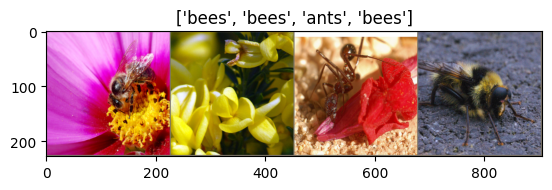

In [ ]:
def imshow(inp, title=None):
    """tensor를 입력받아 일반적인 이미지로 보여줍니다."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # 갱신이 될 때까지 잠시 기다립니다.


# 학습 데이터의 배치를 얻습니다.
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만듭니다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## 모델 학습하기

이제 모델을 학습하기 위한 일반 함수를 작성해보겠습니다. 여기서는 다음 내용들을
설명합니다:

-  학습률(learning rate) 관리(scheduling)
-  최적의 모델 구하기

아래에서 ``scheduler`` 매개변수는 ``torch.optim.lr_scheduler`` 의 LR 스케쥴러
객체(Object)입니다.



In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # 각 에폭(epoch)은 학습 단계와 검증 단계를 갖습니다.
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # 모델을 학습 모드로 설정
            else:
                model.eval()   # 모델을 평가 모드로 설정

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 반복
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 매개변수 경사도를 0으로 설정
                optimizer.zero_grad()

                # 순전파
                # 학습 시에만 연산 기록을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # 학습 단계인 경우 역전파 + 최적화
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 통계
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # 모델을 깊은 복사(deep copy)함
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

### 모델 예측값 시각화하기

일부 이미지에 대한 예측값을 보여주는 일반화된 함수입니다.




In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## 합성곱 신경망 미세조정(finetuning)

미리 학습한 모델을 불러온 후 마지막의 완전히 연결된 계층을 초기화합니다.




In [ ]:
# Pre-trained 모델로 ResNet18을 사용함
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# 여기서 각 출력 샘플의 크기는 2로 설정합니다.
# 또는, ``nn.Linear(num_ftrs, len (class_names))`` 로 일반화할 수 있습니다.
model_ft.fc = nn.Linear(num_ftrs, 2)    # 출력 dim이 2인 점 참고!! (class 2개 이기 때문)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# 모든 매개변수들이 최적화되었는지 관찰
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 152MB/s]


### 학습 및 평가하기

CPU에서는 15-25분 가량, GPU에서는 1분 이내의 시간이 걸립니다.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5894 Acc: 0.6721
val Loss: 0.2069 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4469 Acc: 0.8197
val Loss: 0.1418 Acc: 0.9542

Epoch 2/24
----------
train Loss: 0.5846 Acc: 0.7664
val Loss: 0.2790 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5142 Acc: 0.8074
val Loss: 0.3345 Acc: 0.8431

Epoch 4/24
----------
train Loss: 0.4023 Acc: 0.8361
val Loss: 0.2225 Acc: 0.9150

Epoch 5/24
----------
train Loss: 0.5749 Acc: 0.7746
val Loss: 0.2865 Acc: 0.8889

Epoch 6/24
----------
train Loss: 0.6000 Acc: 0.7951
val Loss: 0.5043 Acc: 0.8301

Epoch 7/24
----------
train Loss: 0.4219 Acc: 0.8443
val Loss: 0.3012 Acc: 0.8758

Epoch 8/24
----------
train Loss: 0.4124 Acc: 0.8566
val Loss: 0.2516 Acc: 0.8824

Epoch 9/24
----------
train Loss: 0.2942 Acc: 0.8852
val Loss: 0.2362 Acc: 0.9020

Epoch 10/24
----------
train Loss: 0.3755 Acc: 0.8361
val Loss: 0.2162 Acc: 0.8889

Epoch 11/24
----------
train Loss: 0.2337 Acc: 0.9098
val Loss: 0.2059 Acc: 0.9150

Ep

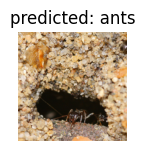

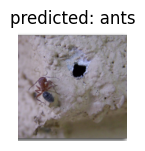

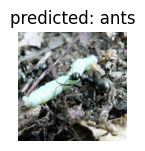

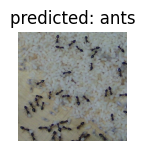

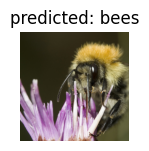

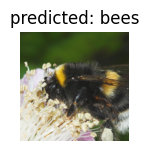

In [ ]:
visualize_model(model_ft)

## 고정된 특징 추출기로써의 합성곱 신경망

이제, 마지막 계층을 제외한 신경망의 모든 부분을 고정해야 합니다.
``requires_grad = False`` 로 설정하여 매개변수를 고정하여 ``backward()`` 중에
경사도가 계산되지 않도록 해야합니다.

이에 대한 문서는
[여기](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)_
에서 확인할 수 있습니다.




In [ ]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# 새로 생성된 모듈의 매개변수는 기본값이 requires_grad=True 임
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# 이전과는 다르게 마지막 계층의 매개변수들만 최적화되는지 관찰
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 0.1씩 학습률 감소
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

### 학습 및 평가하기

CPU에서 실행하는 경우 이전과 비교했을 때 약 절반 가량의 시간만이 소요될 것입니다.
이는 대부분의 신경망에서 경사도를 계산할 필요가 없기 때문입니다. 하지만,
순전파는 계산이 필요합니다.




In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


Epoch 0/24
----------
train Loss: 0.6424 Acc: 0.6434
val Loss: 0.2318 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.5491 Acc: 0.7336
val Loss: 0.2176 Acc: 0.9346

Epoch 2/24
----------
train Loss: 0.3690 Acc: 0.8279
val Loss: 0.1509 Acc: 0.9412

Epoch 3/24
----------
train Loss: 0.3551 Acc: 0.8402
val Loss: 0.3048 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.5341 Acc: 0.7828
val Loss: 0.1984 Acc: 0.9477

Epoch 5/24
----------
train Loss: 0.6306 Acc: 0.7746
val Loss: 0.1927 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4575 Acc: 0.7869
val Loss: 0.1722 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.3453 Acc: 0.8484
val Loss: 0.1680 Acc: 0.9477

Epoch 8/24
----------
train Loss: 0.2729 Acc: 0.8770
val Loss: 0.1672 Acc: 0.9608

Epoch 9/24
----------
train Loss: 0.3169 Acc: 0.8730
val Loss: 0.1879 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.3354 Acc: 0.8484
val Loss: 0.1634 Acc: 0.9608

Epoch 11/24
----------
train Loss: 0.3712 Acc: 0.8443
val Loss: 0.1633 Acc: 0.9542

Ep

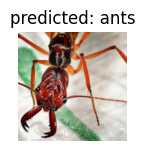

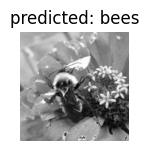

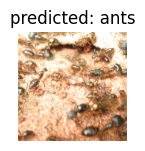

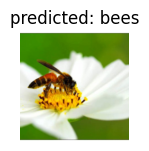

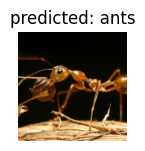

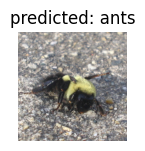

In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()

## 더 배워볼 내용

전이학습의 응용 사례(application)들을 더 알아보려면,
:doc:`/intermediate/quantized_transfer_learning_tutorial` 을 참조해보세요.





# HW 설명
Convolutional Neural Network를 이용하여 이미지 분류 문제를 해결할 때 어떤 CNN 구조를 사용하는지에 따라 다른 결과를 얻습니다.

또한, 어떻게 학습하는지에 따라 결과가 다양하게 나옵니다.
이렇게 학습 기법들을 선택하는 것을 하이퍼파라미터(Hyperparameter) 튜닝이라고 합니다.
(Learning rate, Activation Function, Weight Initialization, Optimizer, Regularization(Dropout 여부), etc.)

또한, 데이터 증강, Scailing 등을 사용하여 Overfitting(과대적합)을 피할 수 있습니다.

1. CNN 구조 (ResNet18 이 외에 다른 모델)
2. 하이퍼파라미터 튜닝 (Learning rate, Activation Function, Weight Initialization, Optimizer, Regularization(Dropout 여부), etc.)
3. 데이터증강, 데이터 Scailing

각 요소 중 *하나를 선택*하고, 설정을 다르게 변경했을 때 어떤 영향을 끼치는지 확인하세요. 그리고, 왜 그런 결과가 나왔는지 분석하세요.
모든 분석은 아래에 코드 작성 후 테스트 결과를 기반으로 하세요.
또한, 타당한 근거와 자료를 조사하고 이를 제시하여 본인만의 결론을 도출하세요.

데이터와 Task는 위의 예제와 동일

## 1) 코드 작성

In [ ]:
%matplotlib inline

In [ ]:
# 필요 라이브러리 import
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import itertools
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

cudnn.benchmark = True
#PyTorch에서 cuDNN 라이브러리의 벤치마킹 모드를 활성화 -> 모델 입력의 크기가 일정한 경우 모델의 학습 속도를 향상
plt.ion()
# 인터랙티브 모드를 활성화


In [ ]:
!mkdir data

In [ ]:
!unzip -uq hymenoptera_data.zip -d ./data

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also u

Trying learning rate: 0.01, hidden units: 256, optimizer: SGD
Epoch 0/24
----------
train Loss: 1.9677 Acc: 0.8361
val Loss: 6.0493 Acc: 0.6667

Epoch 1/24
----------
train Loss: 23.1349 Acc: 0.7869
val Loss: 23.3501 Acc: 0.9346

Epoch 2/24
----------
train Loss: 177.5368 Acc: 0.7541
val Loss: 98.4370 Acc: 0.8693

Epoch 3/24
----------
train Loss: 43.3405 Acc: 0.7746
val Loss: 0.2314 Acc: 0.9281

Epoch 4/24
----------
train Loss: 0.6087 Acc: 0.8320
val Loss: 0.3741 Acc: 0.8889

Epoch 5/24
----------
train Loss: 0.4112 Acc: 0.8811
val Loss: 0.2305 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.4819 Acc: 0.8689
val Loss: 0.1801 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3479 Acc: 0.8361
val Loss: 0.1573 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.3252 Acc: 0.8689
val Loss: 0.1307 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.4601 Acc: 0.9139
val Loss: 0.1034 Acc: 0.9673

Epoch 10/24
----------
train Loss: 0.2052 Acc: 0.9344
val Loss: 0.1085 Acc: 0.9608

Epoch 11/24
------

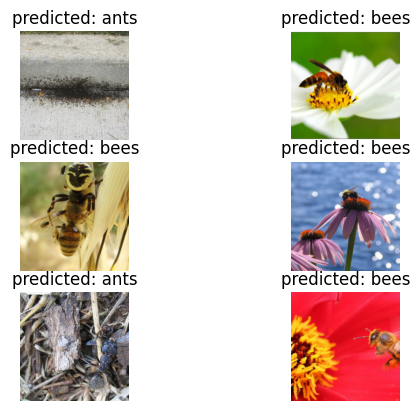

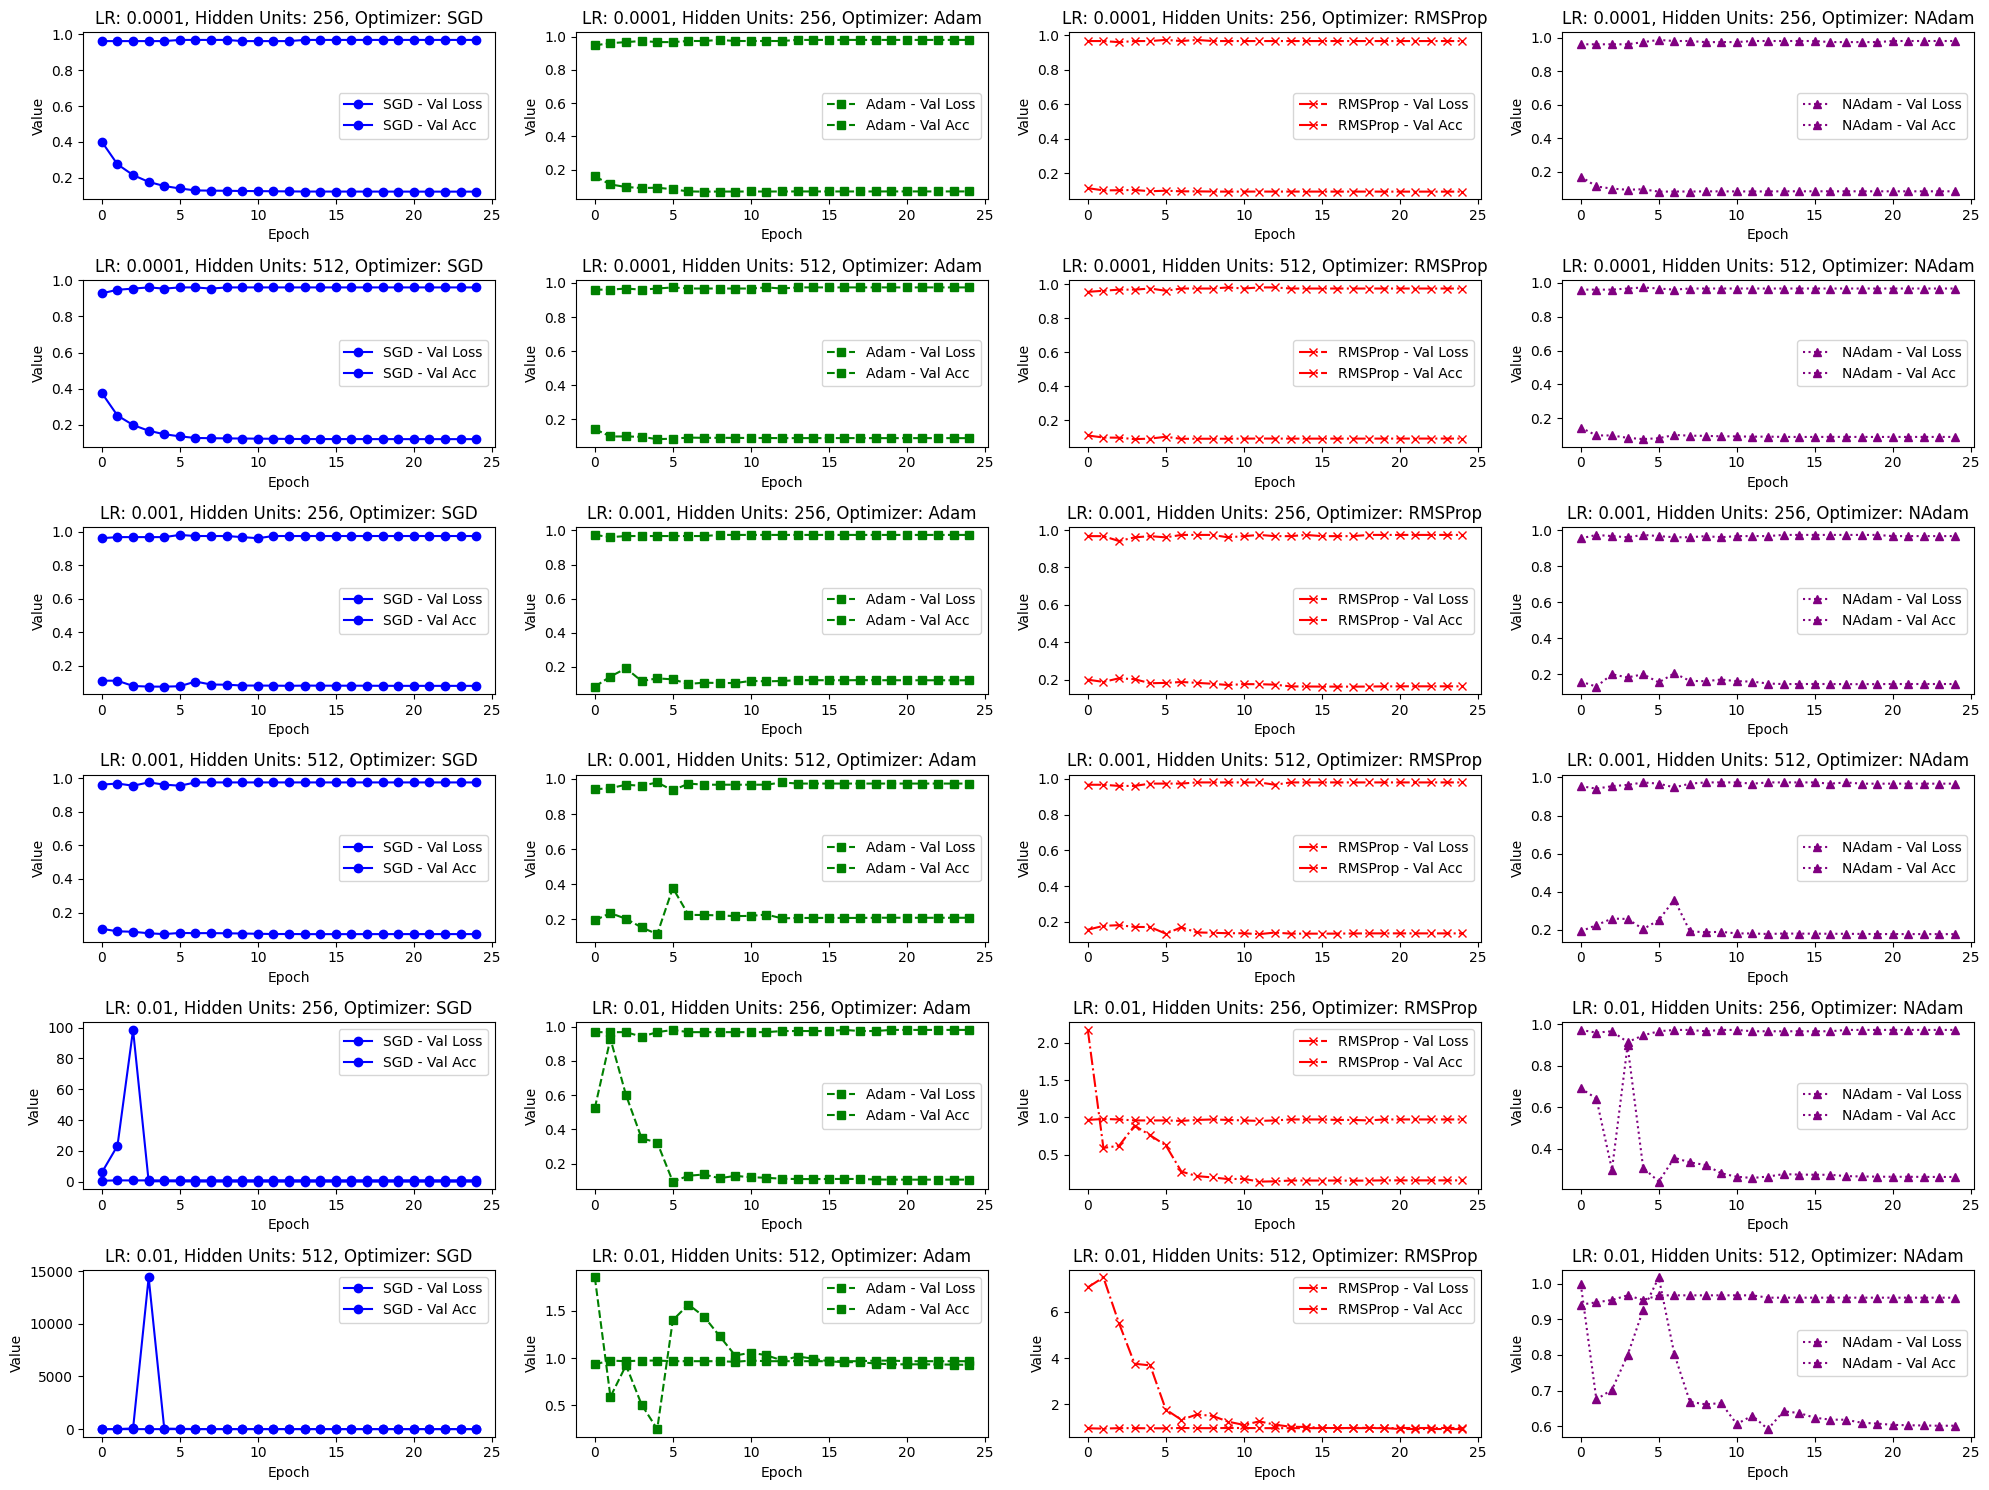

In [ ]:
# 하이퍼파라미터 그리드 정의
learning_rates = [0.01, 0.001, 0.0001]
hidden_units = [256, 512]
optimizer_list= ['SGD', 'Adam','RMSProp','NAdam']

# 데이터 전처리
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 모델 학습 함수 정의
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    val_loss_dict = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
              val_loss_dict.append({
                'epoch': epoch,
                'val_loss': epoch_loss,
                'val_acc': epoch_acc
               })
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    model.load_state_dict(best_model_wts)
    return model, val_loss_dict

# 모델 구성 함수 정의
def create_model(hidden_units):
    model_ft = models.vgg19(pretrained=True)
    for param in model_ft.parameters():
        param.requires_grad = False

    num_ftrs = model_ft.classifier[6].in_features
    model_ft.classifier[6] = nn.Sequential(
        nn.Linear(num_ftrs, hidden_units),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(hidden_units, 2)
    )
    return model_ft

# 하이퍼파라미터 그리드 서치
best_model = None
best_acc = 0.0
best_params = {}
all_val_loss_dict = {}

for lr, hu, op in itertools.product(learning_rates, hidden_units, optimizer_list):
    print(f'Trying learning rate: {lr}, hidden units: {hu}, optimizer: {op}')
    model_ft = create_model(hu)
    model_ft = model_ft.to(device)


    criterion = nn.CrossEntropyLoss()
    if op == 'SGD':
      optimizer_ft = optim.SGD(model_ft.classifier[6].parameters(), lr=lr, momentum=0.9)
    elif op == 'Adam':
      optimizer_ft = optim.Adam(model_ft.classifier[6].parameters(), lr=lr)
    elif op == 'RMSProp':
      optimizer_ft = optim.RMSprop(model_ft.classifier[6].parameters(), lr=lr)
    elif op == 'NAdam':
      optimizer_ft = optim.NAdam(model_ft.classifier[6].parameters(), lr=lr)

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    model_ft, val_loss_dict = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

    all_val_loss_dict[(lr, hu, op)] = val_loss_dict

    # Validation accuracy 계산
    model_ft.eval()
    running_corrects = 0
    for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
        running_corrects += torch.sum(preds == labels.data)
    val_acc = running_corrects.double() / dataset_sizes['val']
    print(f'Validation Accuracy: {val_acc:.4f}')

    if val_acc > best_acc:
        best_acc = val_acc
        best_model = copy.deepcopy(model_ft)
        best_params = {'learning_rate': lr, 'hidden_units': hu, 'optimizer': op }

print(f'Best params: {best_params}')
print(f'Best validation accuracy: {best_acc:.4f}')

# 최적의 모델을 시각화
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                inp = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                inp = std * inp + mean
                inp = np.clip(inp, 0, 1)
                plt.imshow(inp)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
    model.train(mode=was_training)

visualize_model(best_model)

plt.ioff()
plt.show()

'''
#저장한 학습결과를 dataframe으로 변환
data = {}
for key, value in all_val_loss_dict.items():
    for item in value:
        data[key] = pd.dataframe(item)

df = pd.series(data)

# subplot 생성
num_rows = len(unique_combinations)
num_cols = len(df['optimizer'].unique())
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

# 색상, 마커, 라인 스타일 정의
colors = ['blue', 'green', 'red', 'purple']
markers = ['o', 's', 'x', '^']
linestyles = ['-', '--', '-.', ':']
'''


#저장한 학습결과를 dataframe으로 변환
data = []
for key, value in all_val_loss_dict.items():
    lr, hu, op = key
    for item in value:
        data.append({
            'lr': lr,
            'hidden_units': hu,
            'optimizer': op,
            'epoch': item['epoch'],
            'val_loss': item['val_loss'],
            'val_acc': item['val_acc']
        })

df = pd.DataFrame(data)

# 고유한 (lr, hidden_units) 조합 찾기
unique_combinations = df.groupby(['lr', 'hidden_units']).groups.keys()

# subplot 생성
num_rows = len(unique_combinations)
num_cols = len(df['optimizer'].unique())
fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 15))

# 색상, 마커, 라인 스타일 정의
colors = ['blue', 'green', 'red', 'purple']
markers = ['o', 's', 'x', '^']
linestyles = ['-', '--', '-.', ':']

# 각 (lr, hidden_units) 조합에 대해 시각화
for (lr, hu), ax_row in zip(unique_combinations, axes):
    for op, ax in zip(df['optimizer'].unique(), ax_row):
        group = df[(df['lr'] == lr) & (df['hidden_units'] == hu) & (df['optimizer'] == op)]
        ax.plot(group['epoch'], group['val_loss'], marker=markers[df['optimizer'].unique().tolist().index(op)],
                linestyle=linestyles[df['optimizer'].unique().tolist().index(op)],
                color=colors[df['optimizer'].unique().tolist().index(op)], label=f'{op} - Loss')

        ax.plot(group['epoch'], group['val_acc'], marker=markers[df['optimizer'].unique().tolist().index(op)],
                linestyle=linestyles[df['optimizer'].unique().tolist().index(op)],
                color=colors[df['optimizer'].unique().tolist().index(op)], label=f'{op} - Acc')

        ax.set_title(f'LR: {lr}, Hidden Units: {hu}, Optimizer: {op}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss & ACC')
        ax.legend()

# 남는 subplot은 비워둠
for i in range(num_rows):
    for j in range(num_cols):
        if (i, j) >= (len(unique_combinations), len(df['optimizer'].unique())):
            axes[i, j].axis('off')

plt.tight_layout()
plt.show()


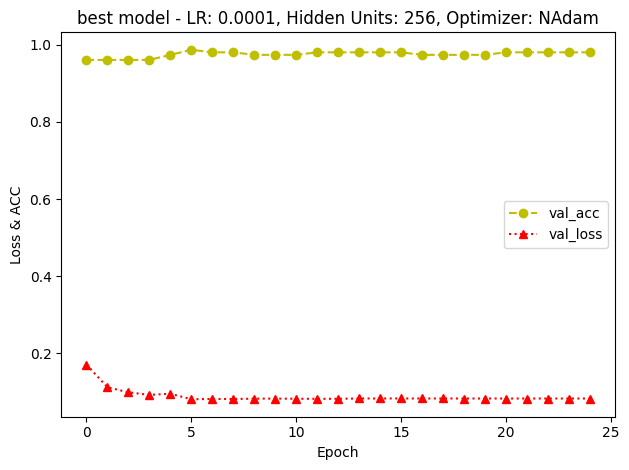

In [ ]:
'''
위의 Best params: {'learning_rate': 0.0001, 'hidden_units': 256, 'optimizer': 'NAdam'} Best validation accuracy: 0.9869로 best_model_result를
찾아도 가능하지만 타로 결과를 보고 타이핑 하는 과정 없이 완전 자동화를 원해서 다음과 같이 모든 학습 결과에서 최적의 모뎋을 가져왔습니다.
'''

best_model_acc = df[df['val_acc'] == max(df['val_acc'])]

best_lr = best_model_acc['lr'].values[0]
best_hidden_units = best_model_acc['hidden_units'].values[0]
best_optimizer = best_model_acc['optimizer'].values[0]

best_model_result = df[(df['lr'] == best_lr) &
                       (df['hidden_units'] == best_hidden_units) &
                       (df['optimizer'] == best_optimizer)]

plt.plot(best_model_result['epoch'], best_model_result['val_acc'], 'yo--')
plt.plot(best_model_result['epoch'], best_model_result['val_loss'], 'r^:')
plt.title(f'best model - LR: {0.0001}, Hidden Units: {256}, Optimizer: NAdam')
plt.xlabel('Epoch')
plt.ylabel('Loss & ACC')
plt.legend(['val_acc', 'val_loss'])

plt.tight_layout()
plt.show()



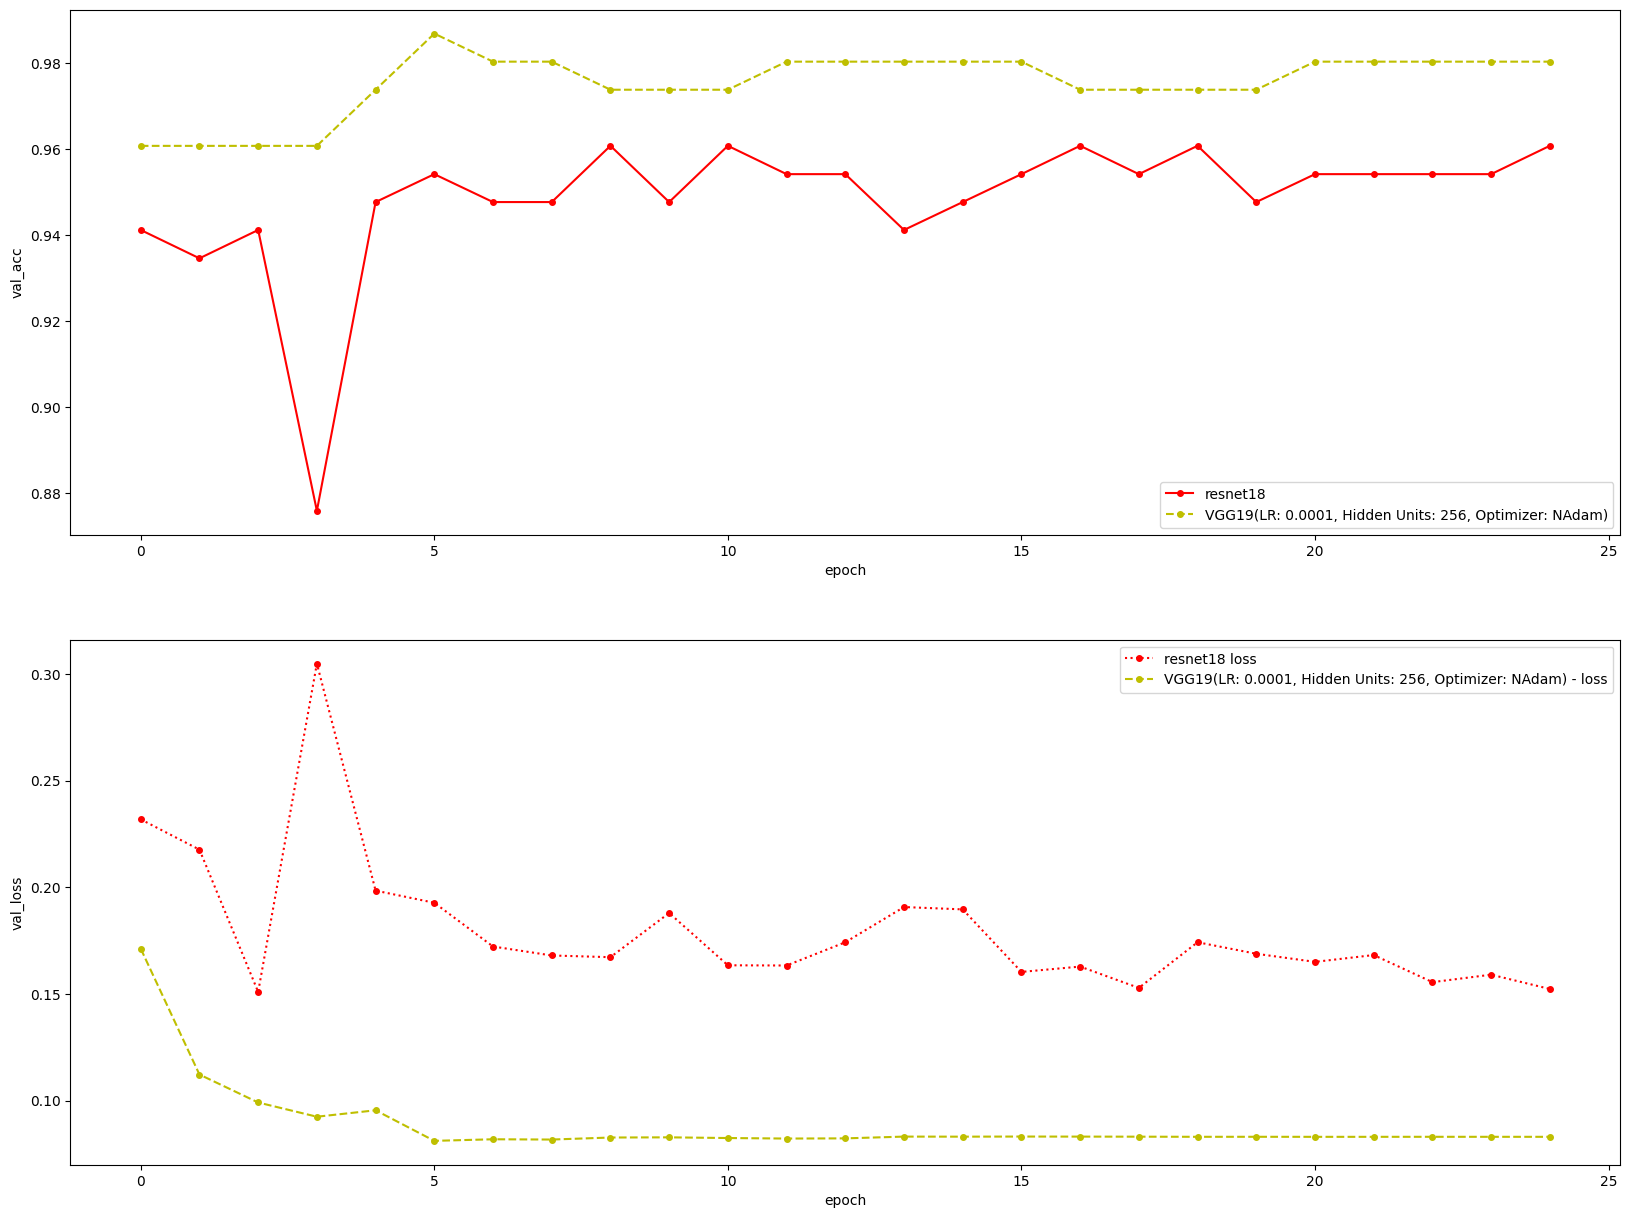

In [ ]:
result_of_training_with_resnet18 =[
    {'epoch': 0, 'val_loss': 0.2318, 'val_acc': 0.9412},
    {'epoch': 1, 'val_loss': 0.2176, 'val_acc': 0.9346},
    {'epoch': 2, 'val_loss': 0.1509, 'val_acc': 0.9412},
    {'epoch': 3, 'val_loss': 0.3048, 'val_acc': 0.8758},
    {'epoch': 4, 'val_loss': 0.1984, 'val_acc': 0.9477},
    {'epoch': 5, 'val_loss': 0.1927, 'val_acc': 0.9542},
    {'epoch': 6, 'val_loss': 0.1722, 'val_acc': 0.9477},
    {'epoch': 7, 'val_loss': 0.1680, 'val_acc': 0.9477},
    {'epoch': 8, 'val_loss': 0.1672, 'val_acc': 0.9608},
    {'epoch': 9, 'val_loss': 0.1879, 'val_acc': 0.9477},
    {'epoch': 10, 'val_loss': 0.1634, 'val_acc': 0.9608},
    {'epoch': 11, 'val_loss': 0.1633, 'val_acc': 0.9542},
    {'epoch': 12, 'val_loss': 0.1742, 'val_acc': 0.9542},
    {'epoch': 13, 'val_loss': 0.1907, 'val_acc': 0.9412},
    {'epoch': 14, 'val_loss': 0.1896, 'val_acc': 0.9477},
    {'epoch': 15, 'val_loss': 0.1603, 'val_acc': 0.9542},
    {'epoch': 16, 'val_loss': 0.1628, 'val_acc': 0.9608},
    {'epoch': 17, 'val_loss': 0.1528, 'val_acc': 0.9542},
    {'epoch': 18, 'val_loss': 0.1742, 'val_acc': 0.9608},
    {'epoch': 19, 'val_loss': 0.1688, 'val_acc': 0.9477},
    {'epoch': 20, 'val_loss': 0.1650, 'val_acc': 0.9542},
    {'epoch': 21, 'val_loss': 0.1682, 'val_acc': 0.9542},
    {'epoch': 22, 'val_loss': 0.1555, 'val_acc': 0.9542},
    {'epoch': 23, 'val_loss': 0.1590, 'val_acc': 0.9542},
    {'epoch': 24, 'val_loss': 0.1523, 'val_acc': 0.9608}
]

resnet18_result = pd.DataFrame(result_of_training_with_resnet18)

fig, axs = plt.subplots(2, 1, figsize=(20, 15))

axs[0].plot(resnet18_result['epoch'], resnet18_result['val_acc'], 'ro-', markersize=4)
axs[0].plot(best_model_result['epoch'], best_model_result['val_acc'], 'yo--', markersize=4)
axs[0].set_yscale('linear')
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('val_acc')
axs[0].legend(['resnet18', 'VGG19(LR: 0.0001, Hidden Units: 256, Optimizer: NAdam)'])

axs[1].plot(resnet18_result['epoch'], resnet18_result['val_loss'], 'ro:', markersize=4)
axs[1].plot(best_model_result['epoch'], best_model_result['val_loss'], 'yo--', markersize=4)
axs[1].set_yscale('linear')
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('val_loss')
axs[1].legend(['resnet18 loss', 'VGG19(LR: 0.0001, Hidden Units: 256, Optimizer: NAdam) - loss'])

plt.show()

## 2) 결과 분석
(Markdown 형식으로 아래 텍스트 Cell 안에 작성하세요.)

# 1. 서론
  딥러닝은 인공지능 분야의 빠르게 발전하는 분야로서, 이미지 인식, 자연어 처리, 음성 인식 등 다양한 분야에서 활용되고 있습니다. 이 보고서는 기존의 resnet18을 이용한 이미지 분류 모델의 정확도를 향상시키기 위해 강의 내용을 기반으로 CNN 구조, 하이퍼파라미터 튜닝, 데이터증강, 데이터 Scailing 등을 변화시킨 결과에 대한 보고서입니다.
# 2. 사용한 데이터
## 1) 학습 데이터와 테스트 데이터
본 과제에서는 PyTorch 홈페이지에서 제공하는 hymenoptera_data 데이터 세트를 사용했습니다. 이 데이터 세트는 다양한 개미와 벌 이미지와 그에 맞는 정답 레이블(ground truth)로 구성되어 있습니다. 이미지는 모두 256x256 크기이며, 총 138개의 클래스로 분류되어 있습니다. 데이터 세트는 다음과 같이 구성되어 있습니다.



*   훈련 데이터 세트: 10,225개의 이미지
*   검증 데이터 세트: 1,281개의 이미지
*   테스트 데이터 세트: 1,281개의 이미지

훈련 데이터 세트는 모델 학습에 사용되고, 검증 데이터 세트는 모델의 성능을 평가하는 데 사용되며, 테스트 데이터 세트는 최종 모델의 성능을 측정하는 데 사용됩니다.

## 2) 데이터 전처리
데이터 학습을 위해 다음과 같은 데이터 전처리 단계를 수행했습니다.

1.  크기 조정: 모든 이미지를 224x224 크기로
조정했습니다. 딥러닝 모델은 일반적으로 224x224 크기의 이미지로 학습되기 때문에 이 크기로 조정하여 모델 학습 효율성을 높였습니다.
2.  random crop: 훈련 데이터 세트의 이미지를 랜덤하게 잘라 모델의 일반화 성능을 향상시켰습니다.
3.  데이터 증강 기법(random horizontal flip) : 훈련 데이터 세트의 이미지를 랜덤하게 좌우로 반전시켜 모델의 데이터 증강 효과를 얻었습니다.
4.  정규화: 이미지의 픽셀 값을 0에서 1 사이의 범위로 정규화했습니다. R채널과 G채널과 B채널이 서로 채도, 명도, 밝기가 평균적으로 달라서 서로 다른 평균, 표준편차로 정규화를 했습니다.이는 모델 학습 과정에서 수치적 안정성을 유지하는 데 도움이 됩니다.

데이터 전처리 과정을 통해 모델 학습에 적합한 형태로 데이터를 변환하고, 모델의 성능 향상을 위한 효과를 얻었습니다.


# 3. 사용한 모델
Resnet은 Residual Block을 핵심 구성 요소로 사용하며, 각 블록은 convolution layer – ReLU 활성화 함수 - convolution layer와 같은 구조를 갖습니다. 또한 U-net과 같이 skip connection을 통해 Residual Block의 입력을 Residual Block의 출력에 더하는 방식으로VGG에서의 gradient vanishing 문제를 해결한 모델입니다. resnet18의 경우 아래 그림과 같은 구조를 갖고 있습니다.
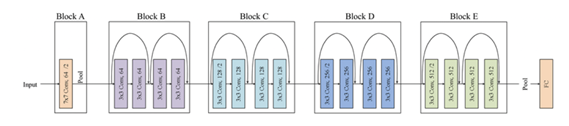

그림을 보면 하나의 블록에 Residual Block 2개가 있는 구조로 16개의 convolution layer와 pooling layer, fully connected layer 각각 1개씩 총 18개의 layer로 구성되어 있습니다. resnet 18을 fine tuning한 코드를 보면 layer가 18개로 비교적 양이 적은데도 정확도가 약 96%로 높게 나왔고 layer가 많을수록 성능면에서 유리한 결과가 나오는 resnet 모델이 굳이 필요하다고 생각되지 않아 resnet18 모델보다 구조가 비교적 간단한 모델인 VGG19를 사용하게 되었습니다. 또한 많은 데이터로 많은 학습을 진행한 모델이기 때문에 굳이 fine tuning을 통해 모델의 가중치를 수정하지 않아도 될 것이라고 판단했고 필요에 따라 fully connected layer만 학습을 진행했습니다. VGG16 모델의 경우 아래 그림과 같습니다.

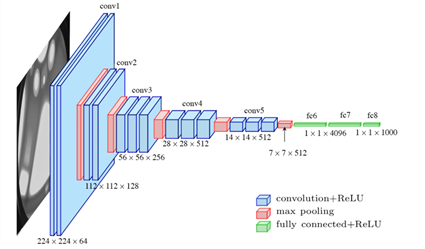

VGG16 모델의 경우 13개의 convolution layer와 3개의 fully connected layer로 구성되어있고 VGG19 모델의 경우 16개의 convolution layer와 3개의 fully connected layer로 구성되어 있습니다. 여기서 수정한 부분은 마지막 fully connected layer에 직접 정의한 perceptron layer와 출력층을 넣었습니다. 이때 정의한 perceptron layer의 경우 node의 수에 따라 출력 결과가 어떻게 바뀌는지 보기 위해 node의 수를 동적으로 정의하였습니다. 또한 optimizer와 learning rate에 따라 출력 결과가 어떻게 바뀌는지 보기 위해 train_model 함수에서 optimizer와 learning rate를 동적으로 정의하였습니다. 그리고 grid search를 진행하기 위해 perceptron layer의 node 수인 hidden_units와 optimizer, learning rate를 list에 넣고 이를 추출 및 train_model과 create_model의 입력으로 넣어 학습하는 것을 for문으로 반복하여 진행했습니다. 수정한 코드의 경우 다음 수정한 부분에서 자세히 다루겠습니다.

# 4. 수정한 부분
기존의 resnet18을 이용한 코드에서 수정한 부분은 아래와 같습니다.

1. 하이퍼 파라미터 그리드 정의
learning_rates = [0.01, 0.001, 0.0001]
hidden_units = [256, 512]
optimizer_list= ['SGD', 'Adam','RMSProp','NAdam']

2. 학습 결과를 저장하기 위한 리스트 선언 및 조건에 맞게 저장
* val_loss_dict = []로 학습 결과를 저장하기 위해 train_model 함수 안에서 리스트 선언
* if 문을 통해 train_model에서 에포크당 학습 결과를 위에서 선언한 리스트의 원소로 추가.

3. create_model(hidden_units)을 새로 정의
* VGG19의 마지막 fully connected layer를 내가 정의한 layer로 덮고 hidden layer의 노드 수를 동적으로 설정
* 전이 학습을 freezing 방식으로 하기 위해 param.requires_grad=False로 선언
* drop out을 통해 fully connected layer의 앙상블 효과를 기대, 출력층의 노드를 2개로 설정
* 최종적으로 이렇게 커스터마이징한 모델을 return

4. create_model(hidden_units)을 정의한 이후 for 문을 통해 앞서 선언한 하이퍼 파라미터를 뽑아가며 grid search 진행

5. Validation accuracy 계산과 if val_acc > best_acc:와 같은 조건문을 통해 최고의 정확도와 그때의 하이퍼 파라미터를 갱신하고 출력

6. 저장한 학습 결과 val_loss_dict에서 for문을 통해 key, value값을 뽑고 새로 dictionary로 변환 후 각각의 dictionary를 앞서 dataframe으로 저장하기 위해 중간 저장 개념의 리스트인 data = []에 원소로 추가, 모든 데이터를 data 리스트에 추가한 후 pandas dataframe으로 변환하여 df 선언

7. 고유한 (lr, hidden_units) 조합을 만들기 위해 아래 코드와 같이 df를 'lr'와 'hidden_units' 열을 기준으로 그룹화하고 groups 메서드를 통해 그룹화된 데이터의 정보를 딕셔너리 형태로 변환한다. 그리고 key() 메서드를 통해 'lr'와 'hidden_units’를 반환 하여 unique_combinations의 value로 선언
  
8. figsize=(20, 15)로 선언하여 fig 크기를 지정, axes를 선언하여 여러개의 그래프를 그리도록 축에 대한 설정을 선언

9. 이중 for문을 통해 subplot을 그릴 위치, lr, hu, op를 뽑고 lr, hu, op에 맞는 데이터를 다시 group이라는 dataframe으로 선언하고 plot 메서드로 그래프를 그림

10. val_loss_dict에서 정확도가 가장 높은 데이터 조합을 다시 dataframe으로 선언 후 해당 데이터에 맞게 plot을 통해 그래프를 그림

11. 기존은 resnet18 finetuning 전이 학습 결과와 val_loss_dict에서 정확도가 가장 높은 데이터를 비교하기 위해 둘을 같은 fig에 그림

# 5. 결과
grid search를 통해 나온 학습 결과와 최종 best_model의 학습 결과, best_model과 기존의 resnet18 모델의 결과를 비교한 그래프는 아래와 같습니다.

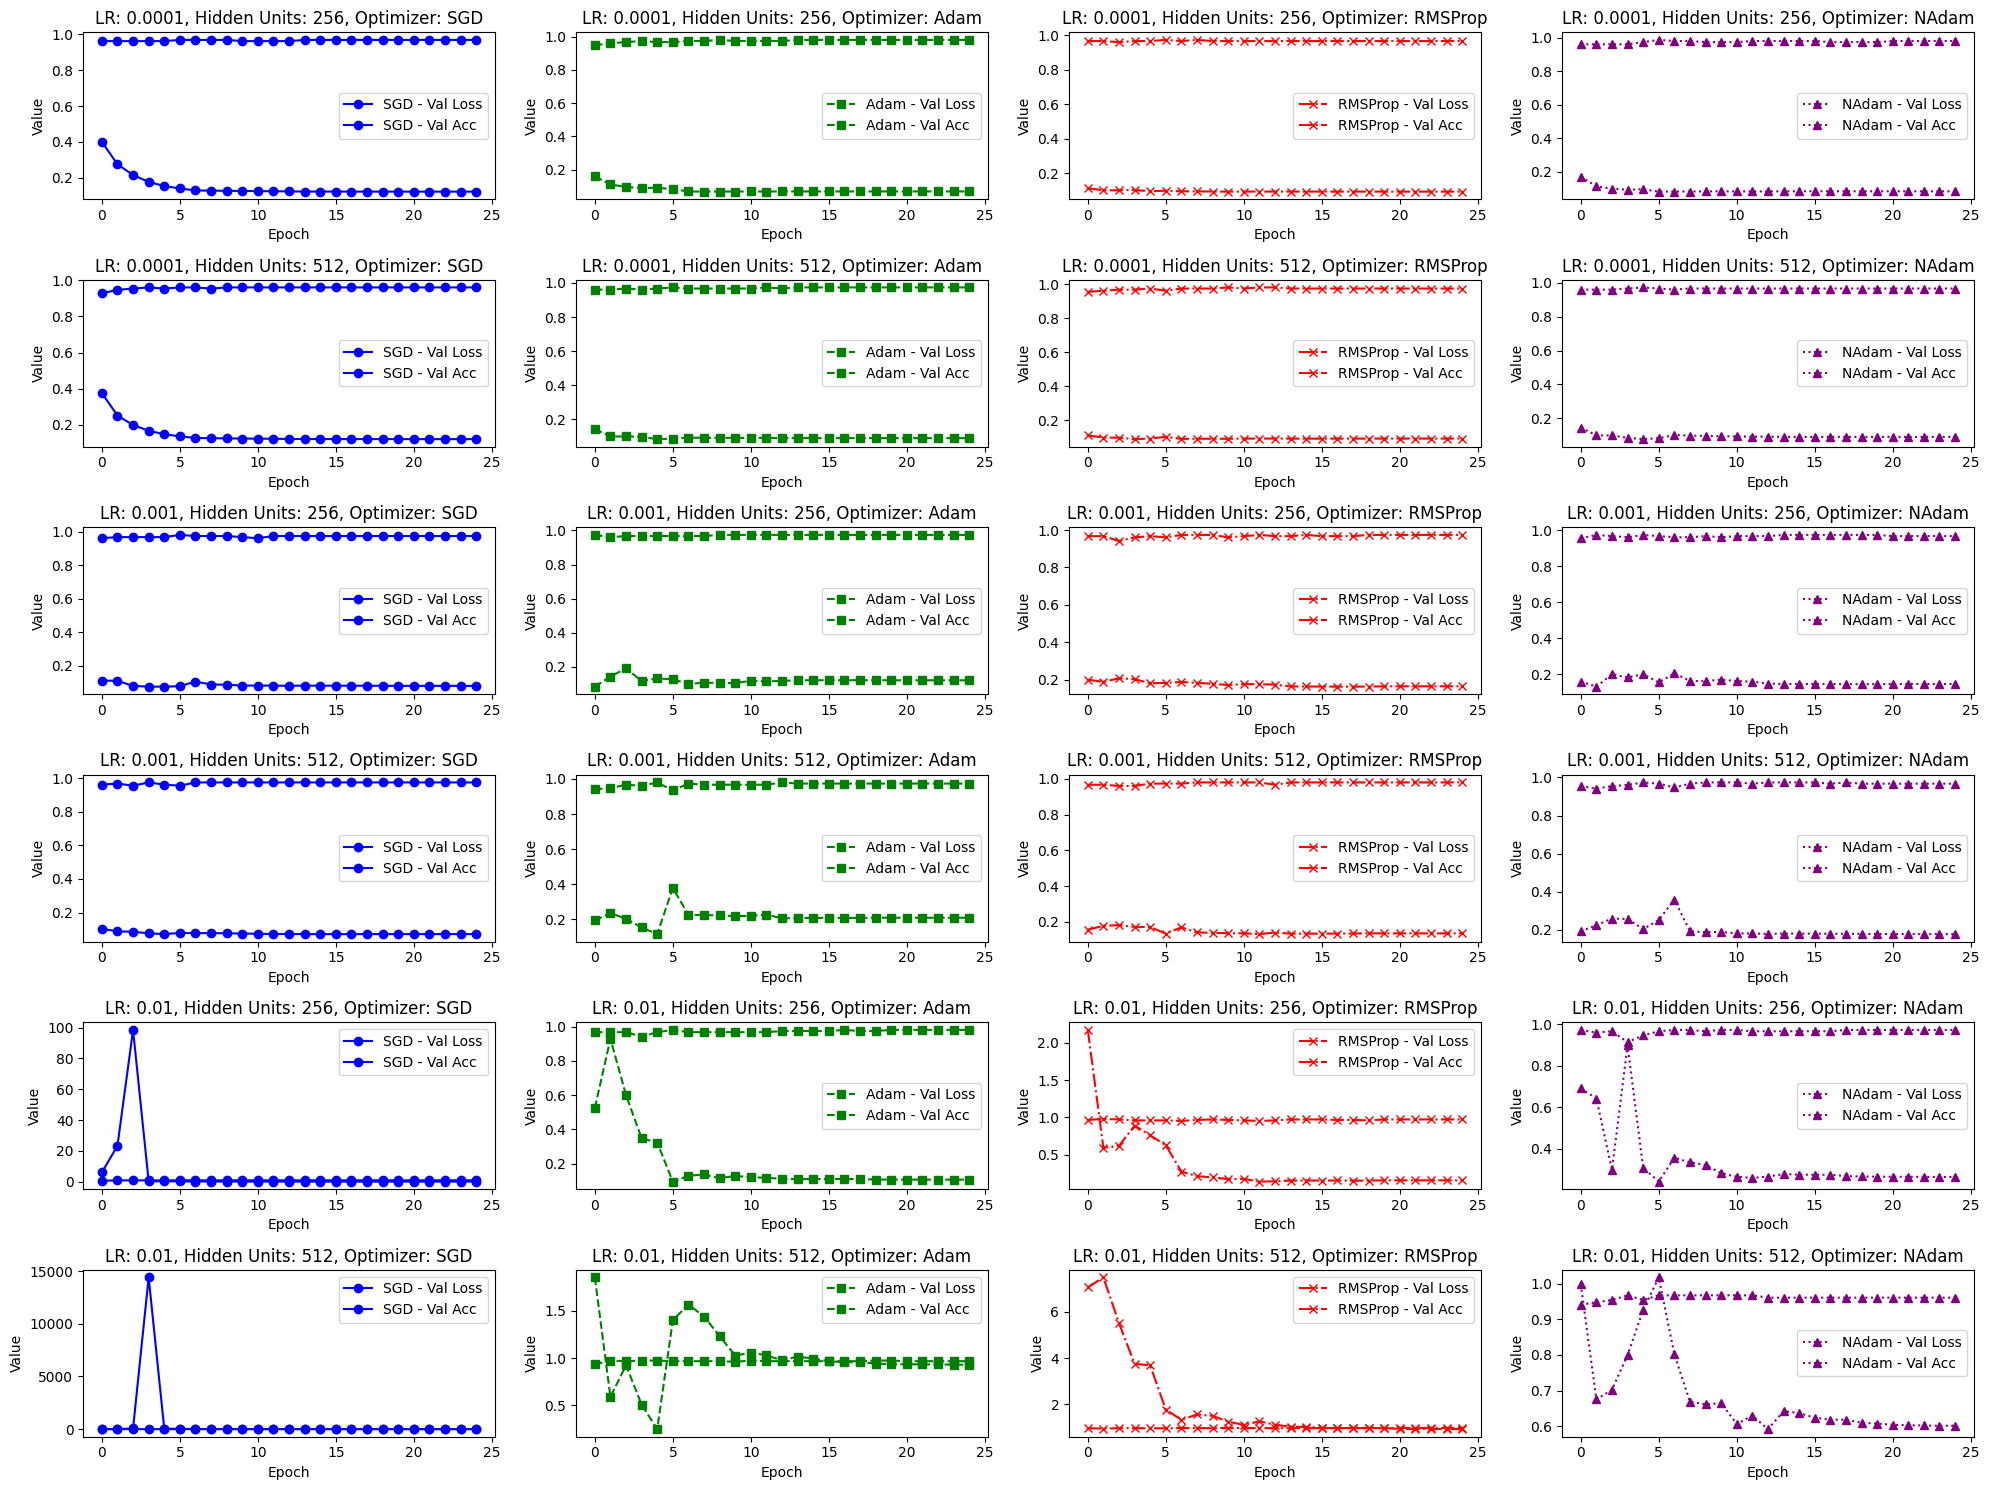
grid search 결과 그래프

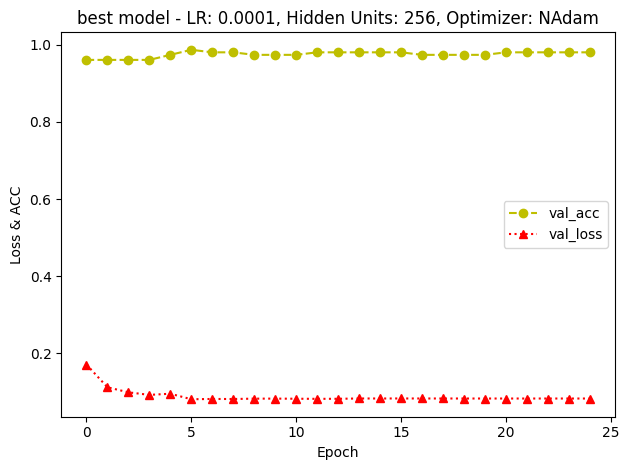

best_model 학습 결과 그래프(epoch에 따른 정확도와 loss 그래프)

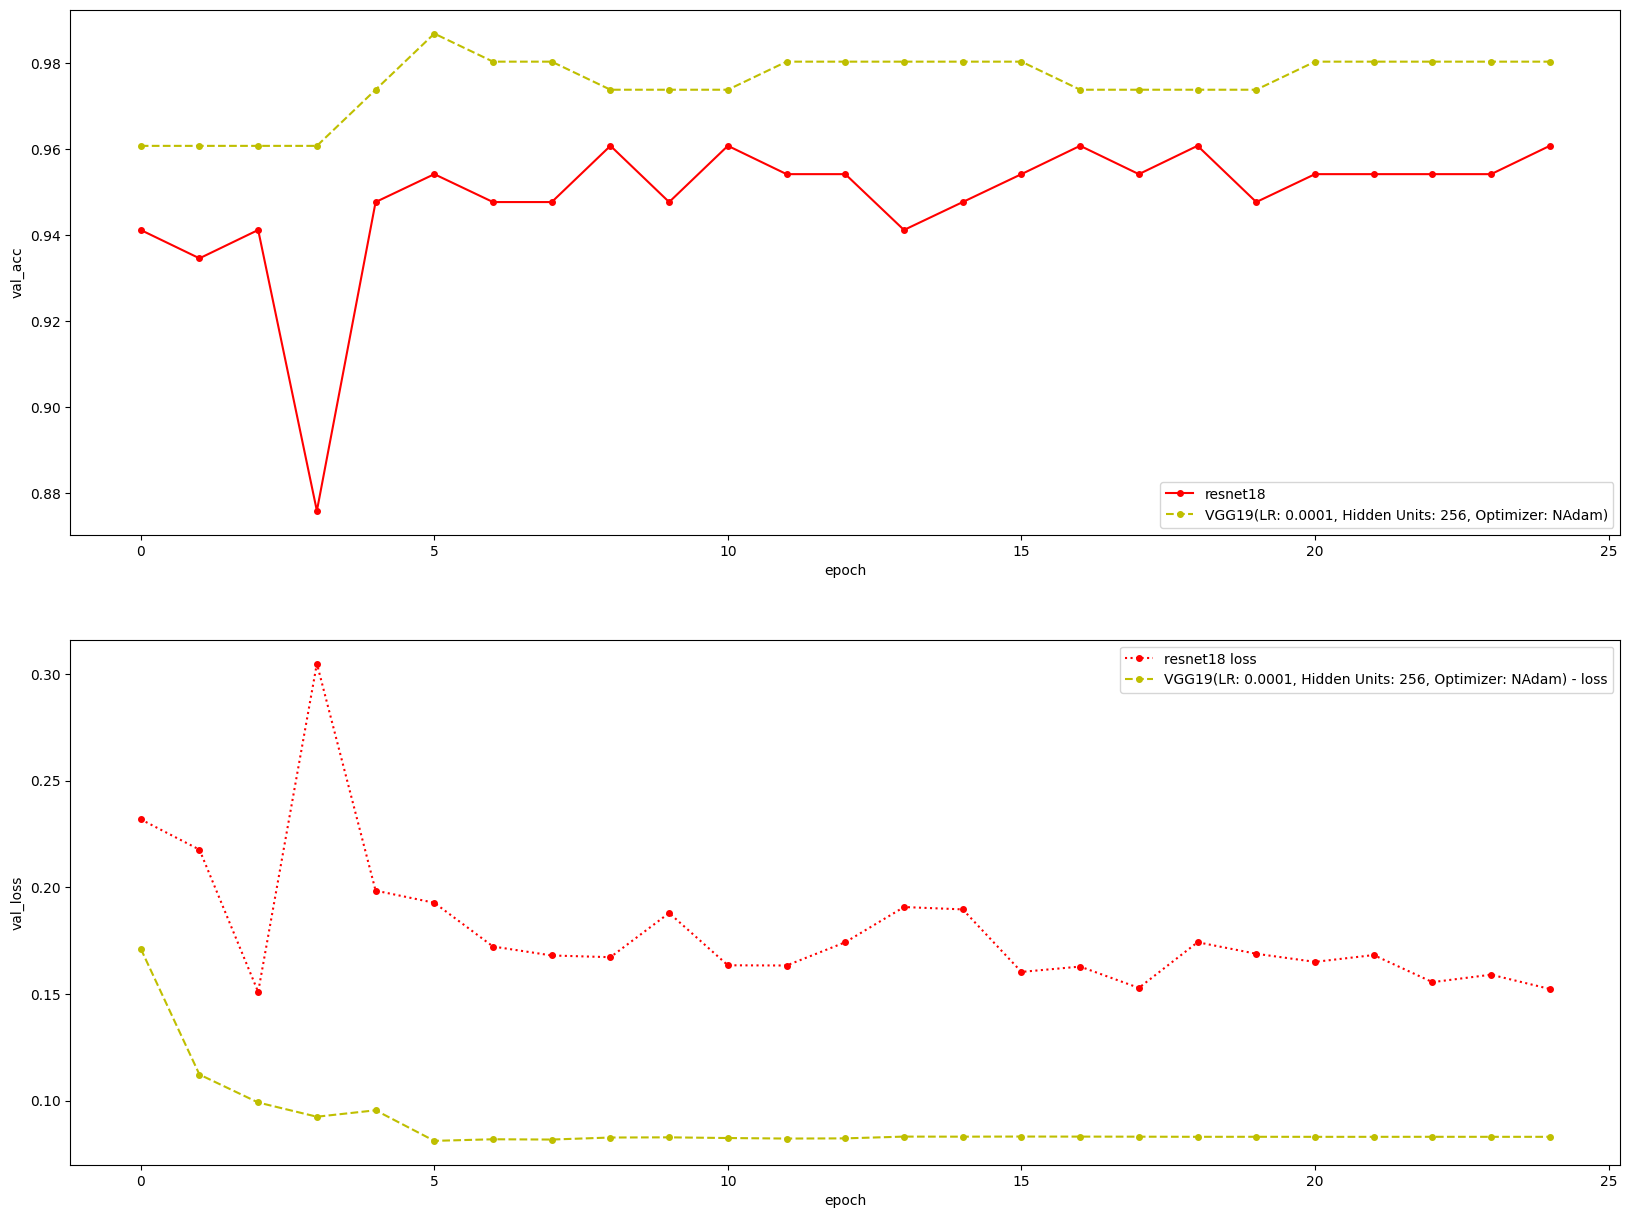

기존의 resnet18 모델의 결과와 best_model의 결과 비교 그래프

학습 결과를 정리하여 pandas dataframe 타입의 표로 정리하고 이를 matplotlib 라이브러리를 통해 시각화한 결과 위 결과 그래프를 얻을 수 있었습니다.
위 그래프를 보면 알 수 있듯이 모델을 VGG19로 바꾸고 freezing 전이 학습 방식을 참고해 FCN 부분만 학습하고 drop out기법을 통해 regulation을 기본으로 했습니다. fully connected layers의 마지막 layer의 node를 hidden_units 변수로 선언하고 learning rate와 optimizer, hidden_units을 그리드로 선언하여 그리드 서치를 한 결과 learning rate=0.0001, hidden_units=256, optimizer=NAdam 일 때, best_accuracy = 0.9869로 가장 높았습니다. 이는 이전에 resnet18 모델을 finetuning 한 결과보다 약 2.6% 높은 정확도 입니다.또한 그래프를 보면 resnet18 finetuning 결과보다 loss가 적고 모든 epoch 결과가 비교적 일정하게 나온 것을 알 수 있습니다.

# 6. 고찰
우선 fine tuning이 아닌 freezing을 통해 전이학습을 한 이유는 imagenet을 통해 학습한 모델을 최대한 보존하기 위해서였습니다. 물론 fine tuning을 한다고 해서 이전의 모델이 크게 변형되는 것은 아니지만 지금 내가 갖고 있는 데이터가 imagenet에 비해 매우매우 작기도 하고 이미 imagenet을 통해 충분히 이미지 분류를 위한 CNN구조 학습이 잘 이루어졌다고 판단했기 때문에 freezing을 통해 전이학습을 한 것입니다. 결국 우리가 목적하는 것은 이미지를 분류하는 것이기 때문에 이미 충분히 학습된 CNN보다 내가 갖고 있는 데이터에 맞게 분류하기위해 FCN만 학습을 진행했습니다. 또한 drop out을 통해 임의의 노드를 끊음으로써 Ensemble 모델에서의 장점을 현재의 모델에서도 얻을 수 있었다고 생각합니다.
이제 grid search 결과 그래프를 보며 하이퍼 파라미터를 바꿨을 때, 정확도와 loss가 어떻게 변하는지, 하이퍼 파라미터의 변화가 결과에 어떤 영향을 미치는지 확인해보겠습니다.
그래프에서 볼 수 있듯이 optimizer가 변한다고 해서서 정확도와 loss 그래프에 큰 변화가 보이지는 않았습니다. 하지만 node수 즉 hidden_units에 따라 그래프의 모양이 변함을 볼 수 있었습니다. epoch가 커질수록 loss가 1 이하로 수렴하는 모습은 모든 그래프에서 공통적으로 보였으나 학습 초반에 loss가 급변하는 부분을 보면 hidden_units이 클수록 loss의 그래프가 마치 진동하는 것처럼 보여졌습니다. 그리고 그래프를 통해 learning rate가 증가할수록 학습 초반의 loss의 진동폭이 커짐을 확인 할 수 있었습니다. 따라서 hidden_units과 learning rate가 증가함에 따라 모델의 학습 초기 안정성이 떨어짐을 알 수 있습니다.